In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
pd.options.display.float_format = '{:,.2f}'.format


In [120]:
def obtener_full_path(directorio):
    return [os.path.join(directorio, file) for file in os.listdir(directorio)]


def plottear(df, x, y, titulo):
    fig, axis = plt.subplots(1, 1, figsize=(19.2, 10.8))
    sns.barplot(data=df, x=x, y=y, ax=axis)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
    fig.suptitle(titulo)
    plt.ticklabel_format(style='plain', axis='y')
    axis.yaxis.set_major_formatter('{x:,}')
    return fig


def obtener_gasto_por_servicio(df_salidas, servicio):
    movimientos_servicio = df_salidas.query('Destino == @servicio and Cantidad > 0')
    articulos_servicio_suma = movimientos_servicio.groupby('Nombre') \
                                                  .sum() \
                                                  .reset_index() \
        .sort_values('Neto Total', ascending=False)

    diez_mas_gastadores = articulos_servicio_suma.sort_values(
        'Neto Total', ascending=False).head(10)
    diez_menos_gastadores = articulos_servicio_suma.sort_values(
        'Neto Total', ascending=False).tail(10)

    print(f'Los 10 artículos que más gastan en {servicio} son:\n'
          f'{diez_mas_gastadores.to_markdown(floatfmt=",.2f")}\n')

    print(f'Los 10 artículos que menos gastan en {servicio} son:\n'
          f'{diez_menos_gastadores.to_markdown(floatfmt=",.2f")}\n')

    figura_articulos_servicio_suma = plottear(
        x='Nombre', y='Neto Total', df=articulos_servicio_suma,
        titulo=f'Gasto por Artículo de {servicio}')

    articulos_qmin, articulos_q1, articulos_q2, articulos_q3, articulos_qmax, \
        figura_df_articulos_min_q1, figura_df_articulos_q1_q2, \
        figura_df_articulos_q2_q3, figura_df_articulos_q3_max = separar_por_cuartil(articulos_servicio_suma, 'Nombre')


def separar_por_cuartil(df_a_separar, columna_a_separar):
    qmin = df_a_separar[columna_a_separar].quantile(0)
    q1 = df_a_separar[columna_a_separar].quantile(0.25)
    q2 = df_a_separar[columna_a_separar].quantile(0.5)
    q3 = df_a_separar[columna_a_separar].quantile(0.75)
    qmax = df_a_separar[columna_a_separar].quantile(1)

    df_min_q1 = df_a_separar.query(
        f'`{columna_a_separar}` >= @qmin and `{columna_a_separar}` < @q1')
    df_q1_q2 = df_a_separar.query(
        f'`{columna_a_separar}` >= @q1 and `{columna_a_separar}` < @q2')
    df_q2_q3 = df_a_separar.query(
        f'`{columna_a_separar}` >= @q2 and `{columna_a_separar}` < @q3')
    df_q3_max = df_a_separar.query(
        f'`{columna_a_separar}` >= @q3 and `{columna_a_separar}` <= @qmax')

    return df_min_q1, df_q1_q2, df_q2_q3, df_q3_max


def analizar_distribucion_de_datos(df, columna_a_analizar, titulo_grafico):
    serie_columna = df[columna_a_analizar]
    descripcion_serie_columna = serie_columna.describe().to_frame().reset_index()
    descripcion_serie_columna = descripcion_serie_columna.rename(columns={'index': 'Estadisticas'})

    mosaico = '''
              AB
              AC
              '''

    fig, axis = plt.subplot_mosaic(mosaico, figsize=(19.2, 10.8), layout='constrained')
    args_plot = [df, columna_a_analizar, titulo_grafico]

    tabla = axis['A'].table(cellText=descripcion_serie_columna.values,
                  colLabels=descripcion_serie_columna.columns, loc='center')
    axis['A'].axis('off')

    sns.histplot(data=args_plot[0], x=args_plot[1], ax=axis['B'])
    sns.boxplot(data=args_plot[0], x=args_plot[1], ax=axis['C'])

    plt.ticklabel_format(style='plain', axis='x')

    axis['B'].set_xticklabels(axis['B'].get_xticklabels(), rotation=45)
    axis['C'].set_xticklabels(axis['C'].get_xticklabels(), rotation=45)
    axis['B'].xaxis.set_major_formatter('{x:,}')
    axis['C'].xaxis.set_major_formatter('{x:,}')

    fig.suptitle(args_plot[2])

    return fig


#     figura_df_articulos_q3_max = plottear(df_articulos_q3_max, eje_x, 'Neto Total', titulo = f'Gasto Total Q4 -> Qmax')
#     figura_df_articulos_q2_q3 = plottear(df_articulos_q2_q3, eje_x, 'Neto Total', titulo = f'Gasto Total Q3 -> Q4')
#     figura_df_articulos_q1_q2 = plottear(df_articulos_q1_q2, eje_x, 'Neto Total', titulo = f'Gasto Total Q1 -> Q2')
#     figura_df_articulos_min_q1 = plottear(df_articulos_min_q1, eje_x, 'Neto Total', titulo = f'Gasto Total Qmin -> Q1')

#     return articulos_qmin, articulos_q1, articulos_q2, articulos_q3, articulos_qmax, \
#         figura_df_articulos_min_q1, figura_df_articulos_q1_q2, \
#         figura_df_articulos_q2_q3, figura_df_articulos_q3_max


In [114]:
df = pd.concat(map(lambda x: pd.read_csv(x, parse_dates=[
               0], dayfirst=True), obtener_full_path('input')))
df = df.sort_values('Fecha')


# Aquí se realizará el análisis del año completo en cuanto a los gastos

In [47]:
df_salidas = df.query('Movimiento == "Salida"')
costos_por_unidades_global = df_salidas.groupby('Destino').sum().reset_index()
costos_por_unidades_global['Porcentaje Gasto'] = costos_por_unidades_global['Neto Total'] / \
                                          costos_por_unidades_global['Neto Total'].sum()

costos_por_unidades_global = costos_por_unidades_global.sort_values('Neto Total', ascending=False)


La distribución de datos de la columna Neto Total es:

count              81.00
mean      165,996,406.59
std       523,054,197.22
min                 0.00
25%           940,620.08
50%        13,754,431.00
75%        80,292,736.00
max     3,324,910,605.30
Name: Neto Total, dtype: float64


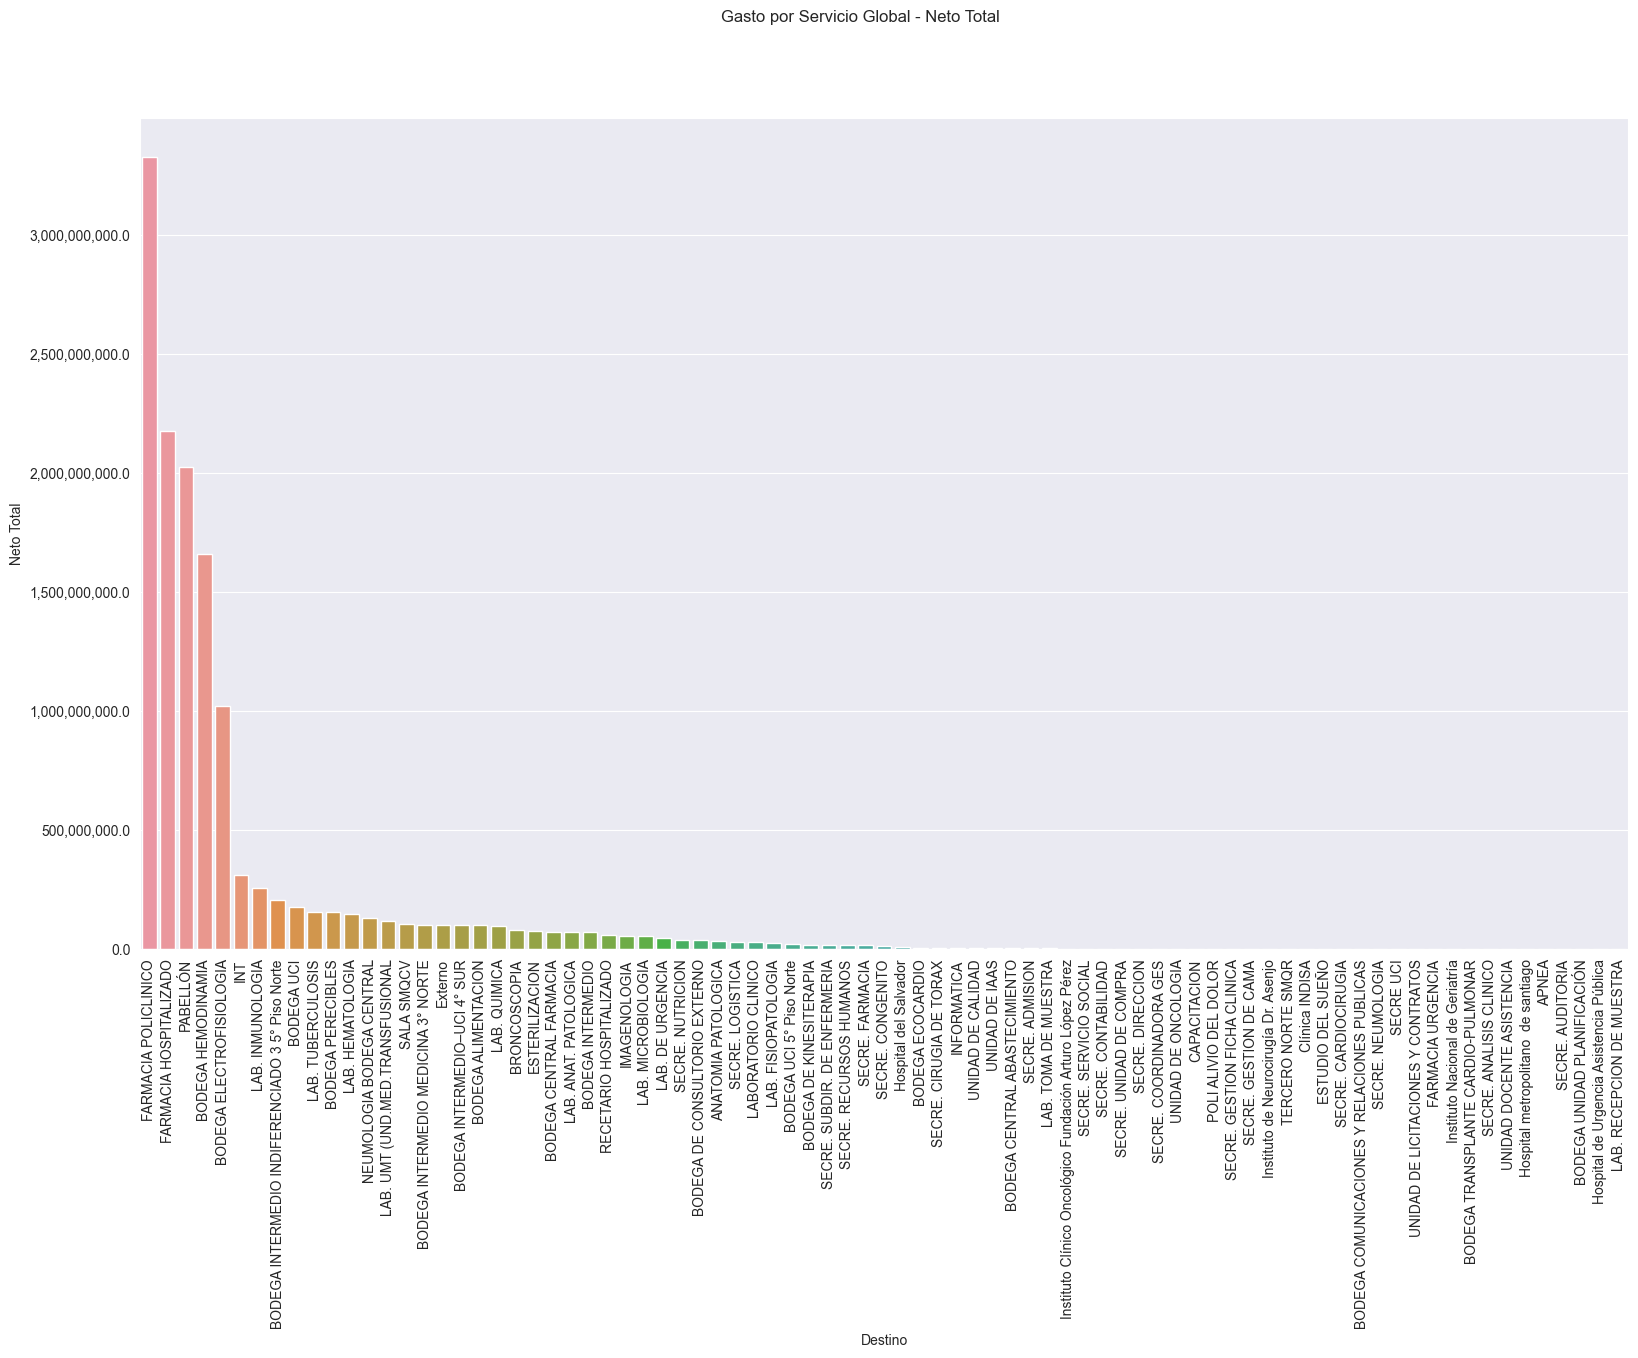

In [48]:
fig_global = plottear(costos_por_unidades_global, 'Destino', 'Neto Total', 'Gasto por Servicio Global - Neto Total')
inter_1, inter_2, inter_3, inter_4 = separar_por_cuartil(costos_por_unidades_global, 'Neto Total')

C:\Users\gmolina\AppData\Local\Temp\ipykernel_25100\1951076967.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis['B'].set_xticklabels(axis['B'].get_xticklabels(), rotation=45)
C:\Users\gmolina\AppData\Local\Temp\ipykernel_25100\1951076967.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis['C'].set_xticklabels(axis['C'].get_xticklabels(), rotation=45)


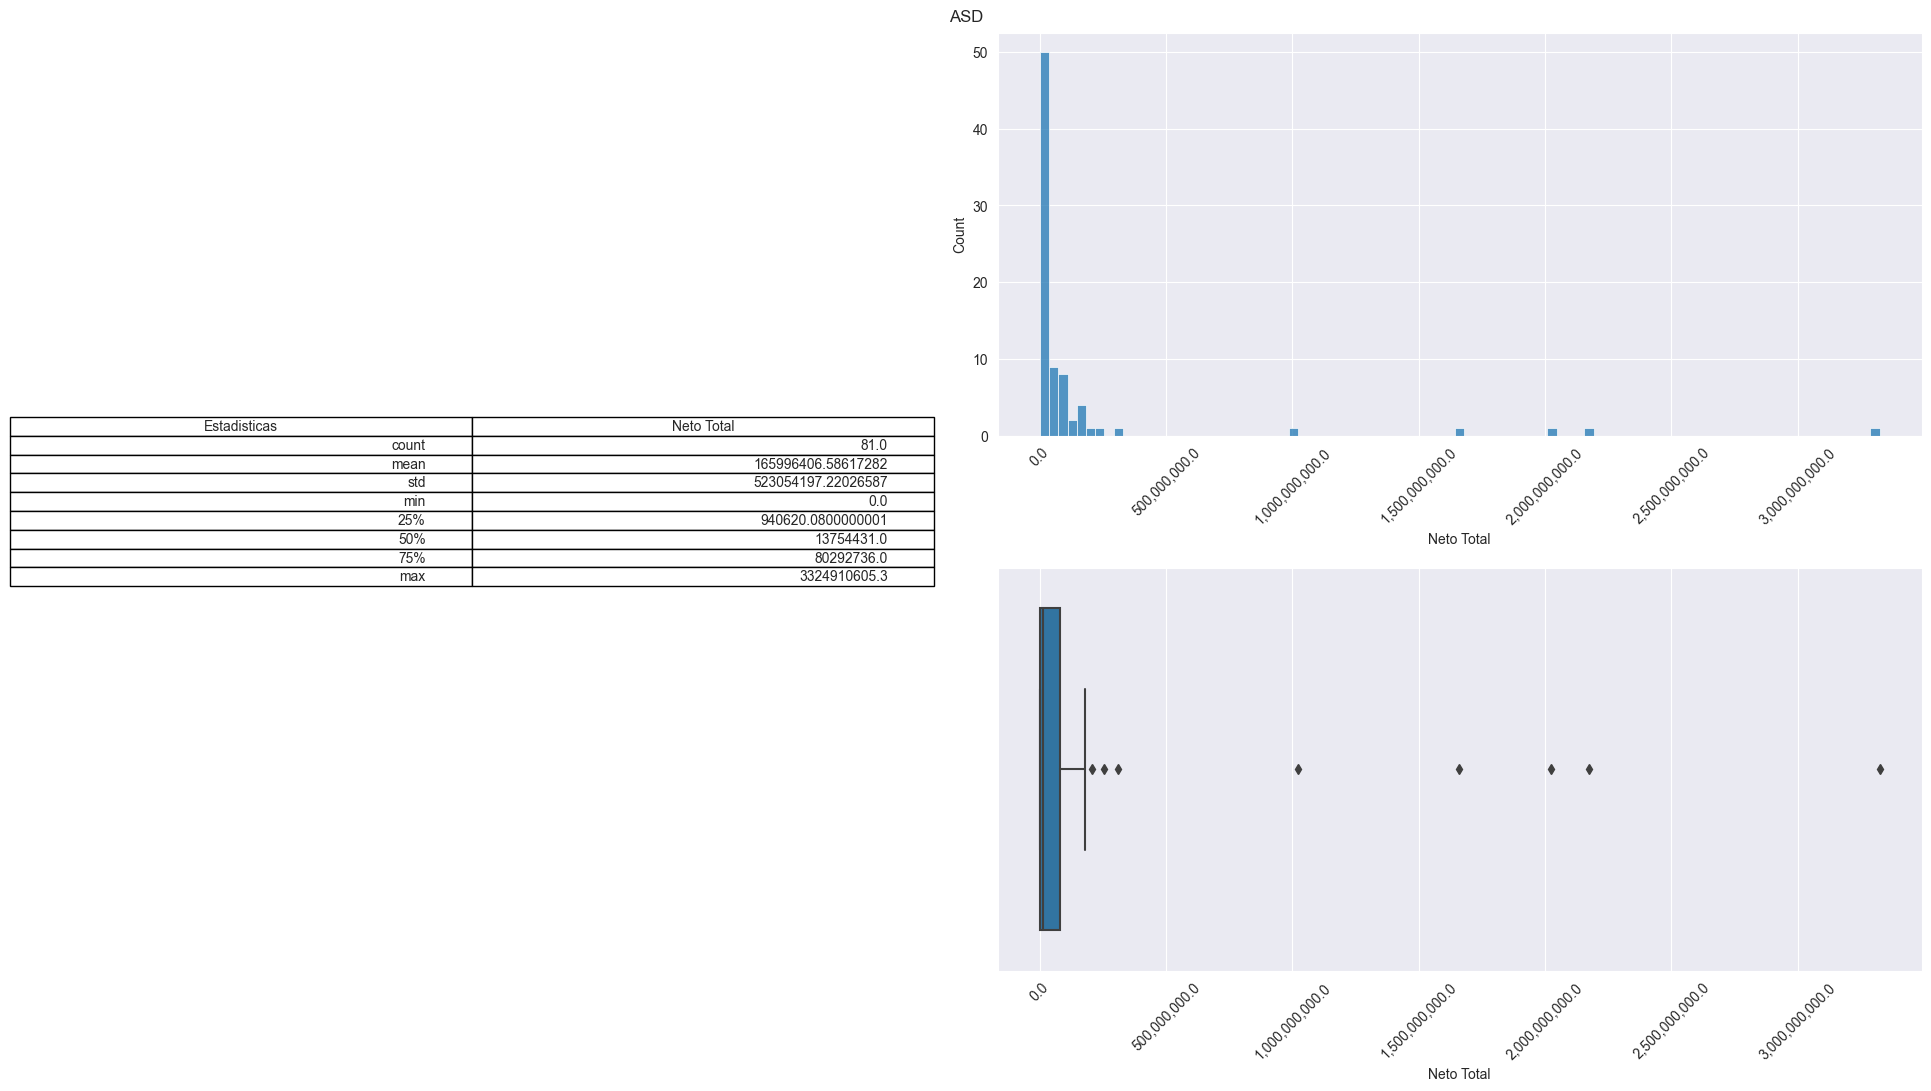

In [121]:
figura_distribucion = analizar_distribucion_de_datos(costos_por_unidades_global, 'Neto Total', 'ASD')

# En este apartado se realizará el análisis de desglose de artículos por servicio. Se observará
# cuales son los artículos que gastan más.

1. En primer lugar, se obtiene el df de los movimientos del servicio que se quiere analizar.
En este apartado se filtran los artículos que tengan una cantidad de 0 (aunque, por qué tienen
una cantidad de 0?)
2. Luego, se obtiene la suma por artículo utilizando un groupby, y sumando.
3. Finalmente, se grafica, ocupando ```x = "Nombre" e y = "Neto Total"```

De esta análisis se quieren responder las siguientes preguntas:

- ¿Cuántos artículos ha solicitado el servicio?
- ¿Cuáles son los 5 artículos que gastan más?

Los 10 artículos que más gastan en FARMACIA POLICLINICO son:
|     | Nombre                                                      |   Cantidad |   Neto Unitario |     Neto Total |
|----:|:------------------------------------------------------------|-----------:|----------------:|---------------:|
| 114 | ILOPROST 10 MCG AMP 1 ML (VENTAVIS)                         |      48442 |      587,781.00 | 544,721,562.00 |
|  19 | AMBRISENTAN 10 MG                                           |      17940 |      448,520.00 | 361,641,600.00 |
| 202 | RH-DORNASA-ALFA 2,5MG/2ML AMPOLLA                           |      16800 |      170,100.00 | 357,210,000.00 |
| 229 | TOBRAMICINA 28 MG CAP INHALACION                            |      33600 |      141,327.83 | 167,327,018.88 |
| 237 | TRIKAFTA ( elexacaftor, tezacaftor, ivacaftor)              |        588 |      277,414.42 | 163,119,678.96 |
| 180 | OSIMERTINIB 80 MG COMPRIMIDO                                |       1080 |      780,000.00 | 140,400,000.

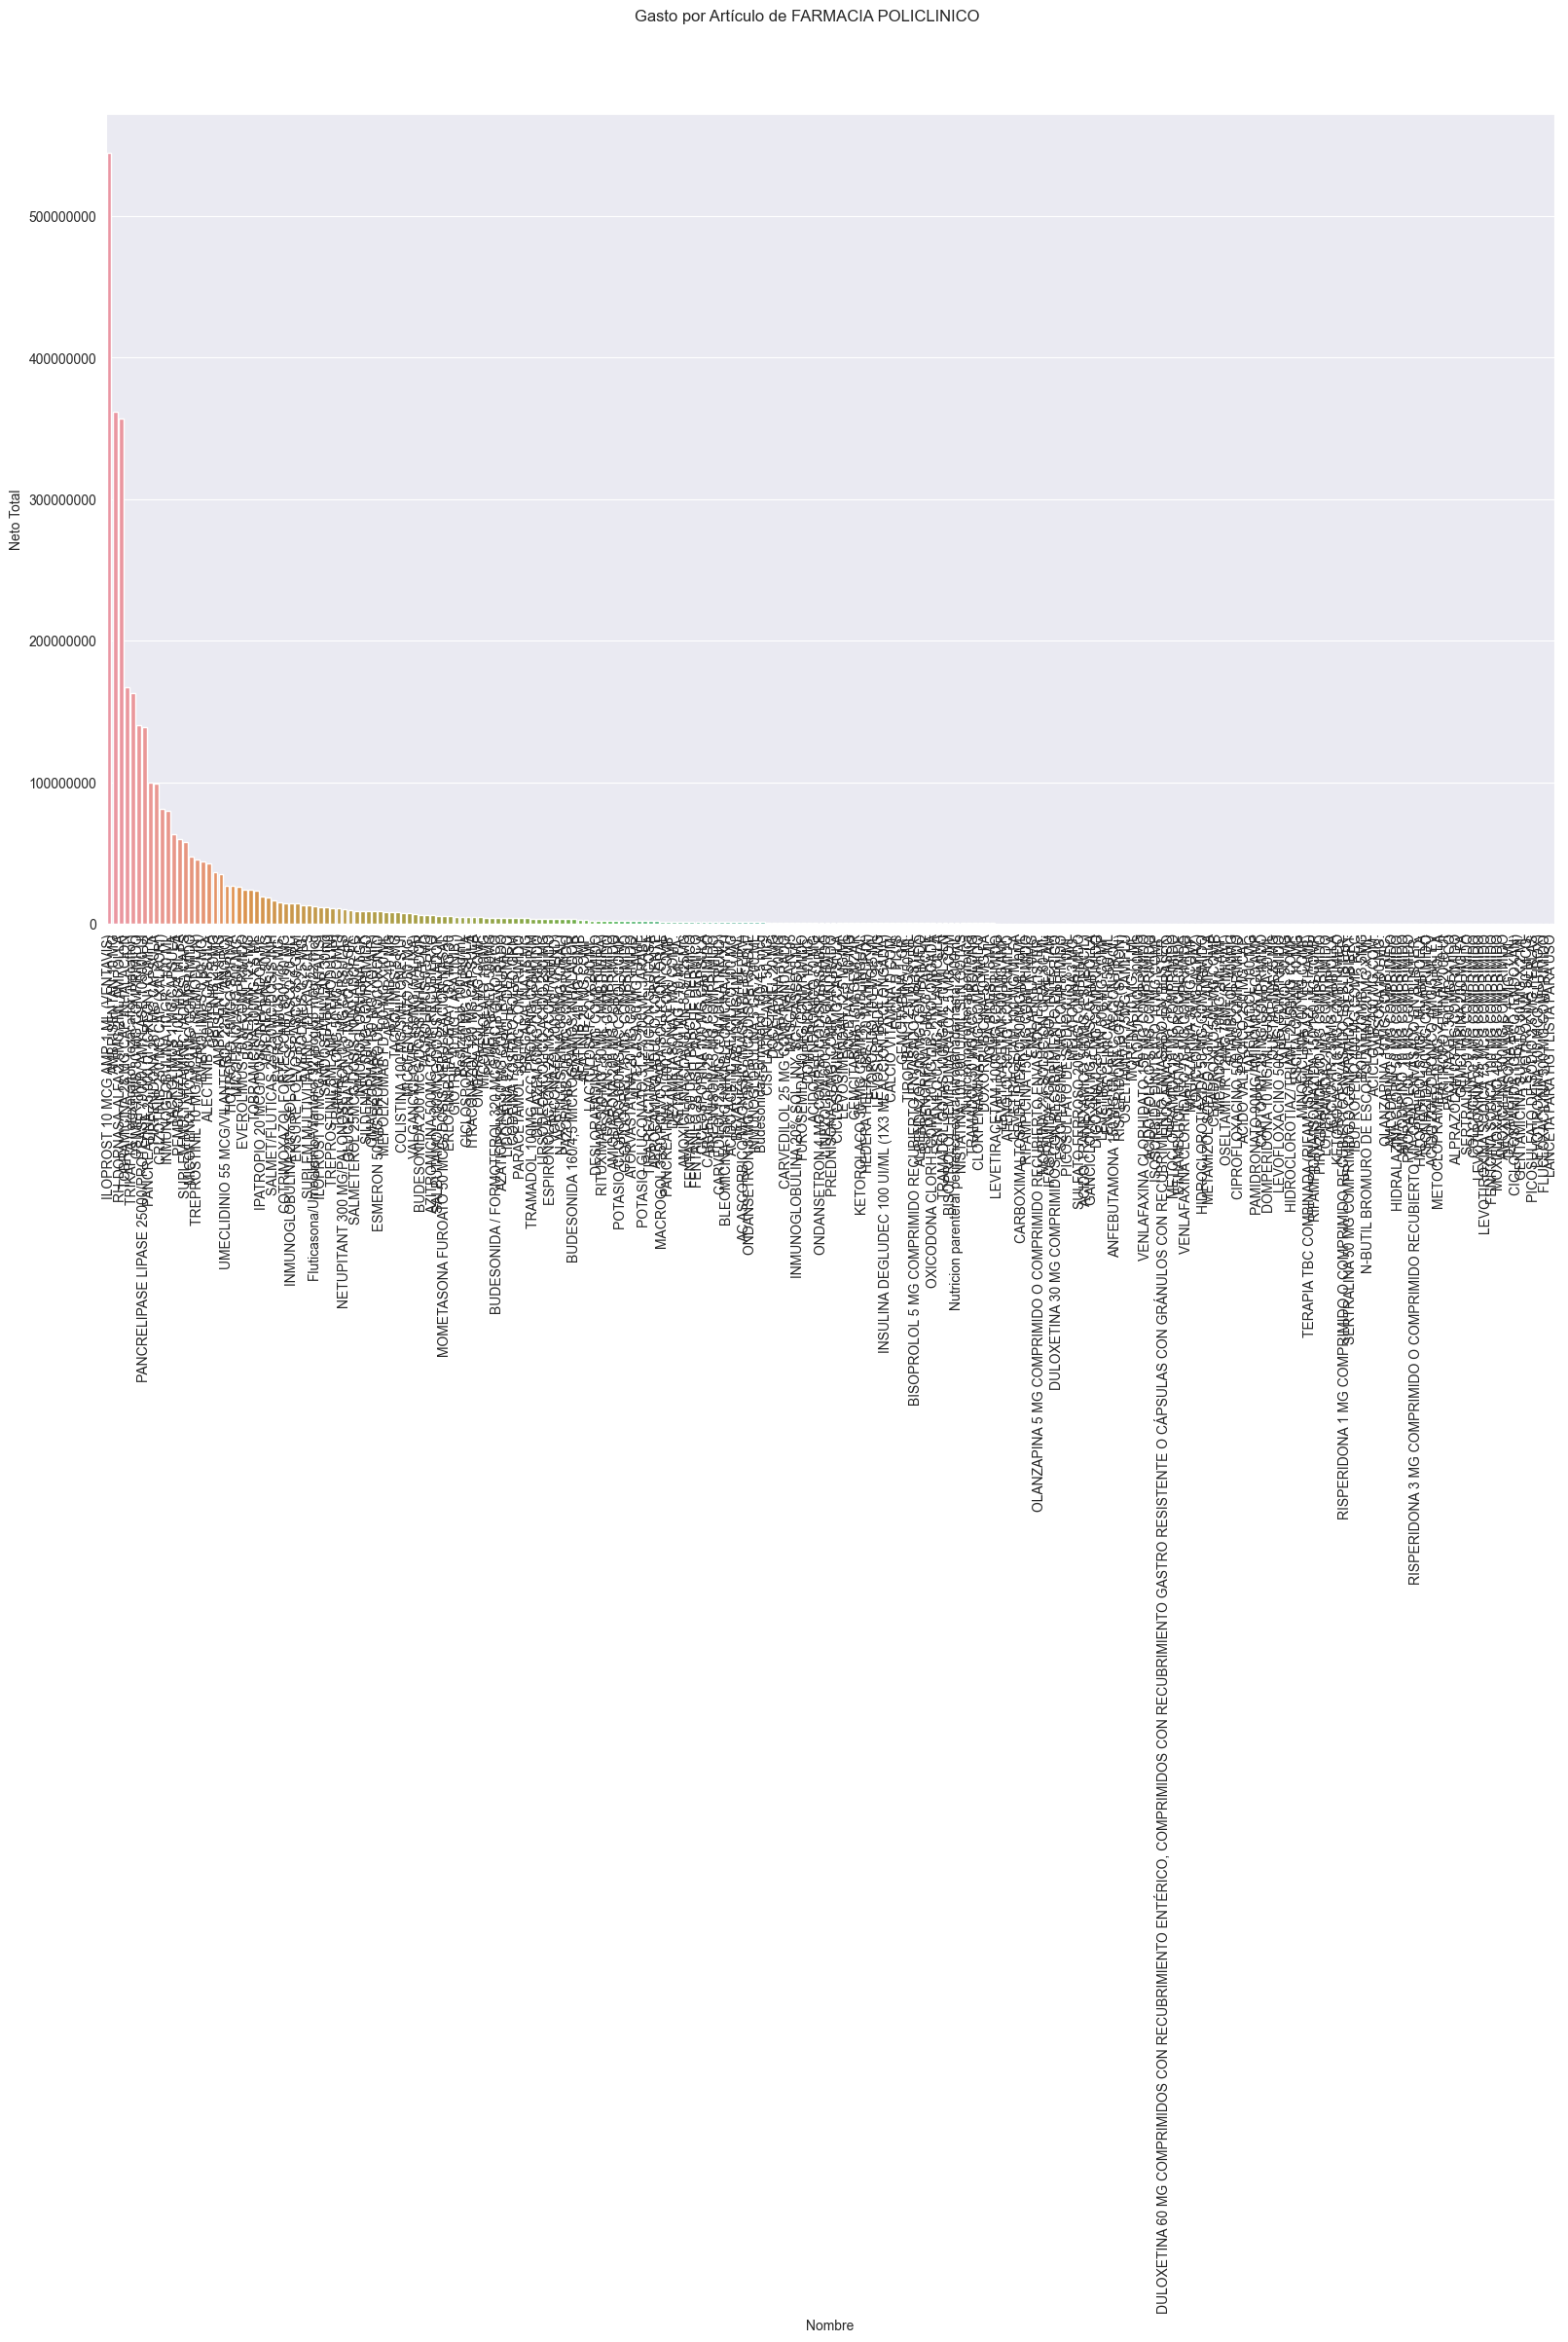

La distribución de datos de la columna Neto Total es:

count           246.00
mean     13,515,896.77
std      52,141,162.51
min               0.00
25%         106,282.50
50%         783,800.00
75%       4,693,281.25
max     544,721,562.00
Name: Neto Total, dtype: float64


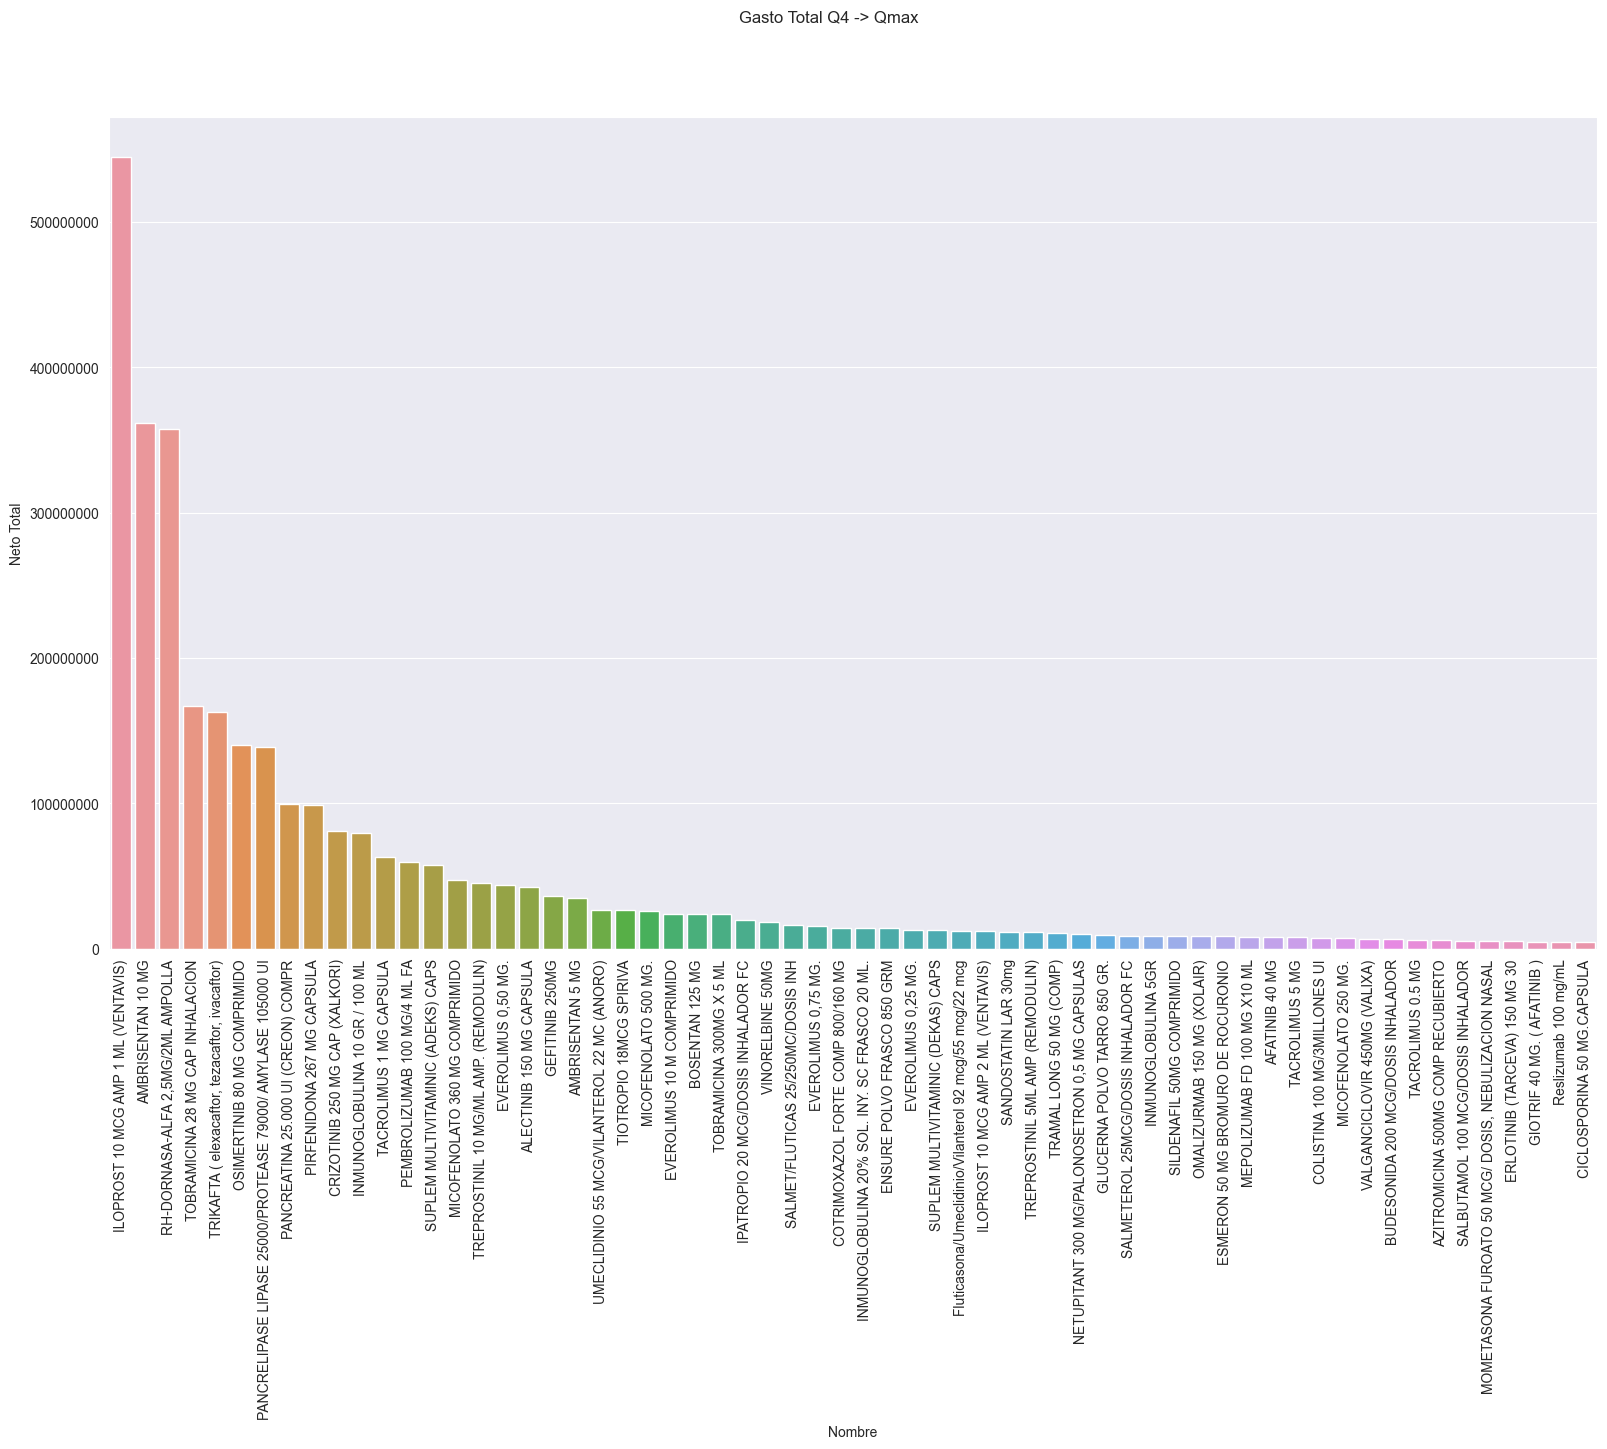

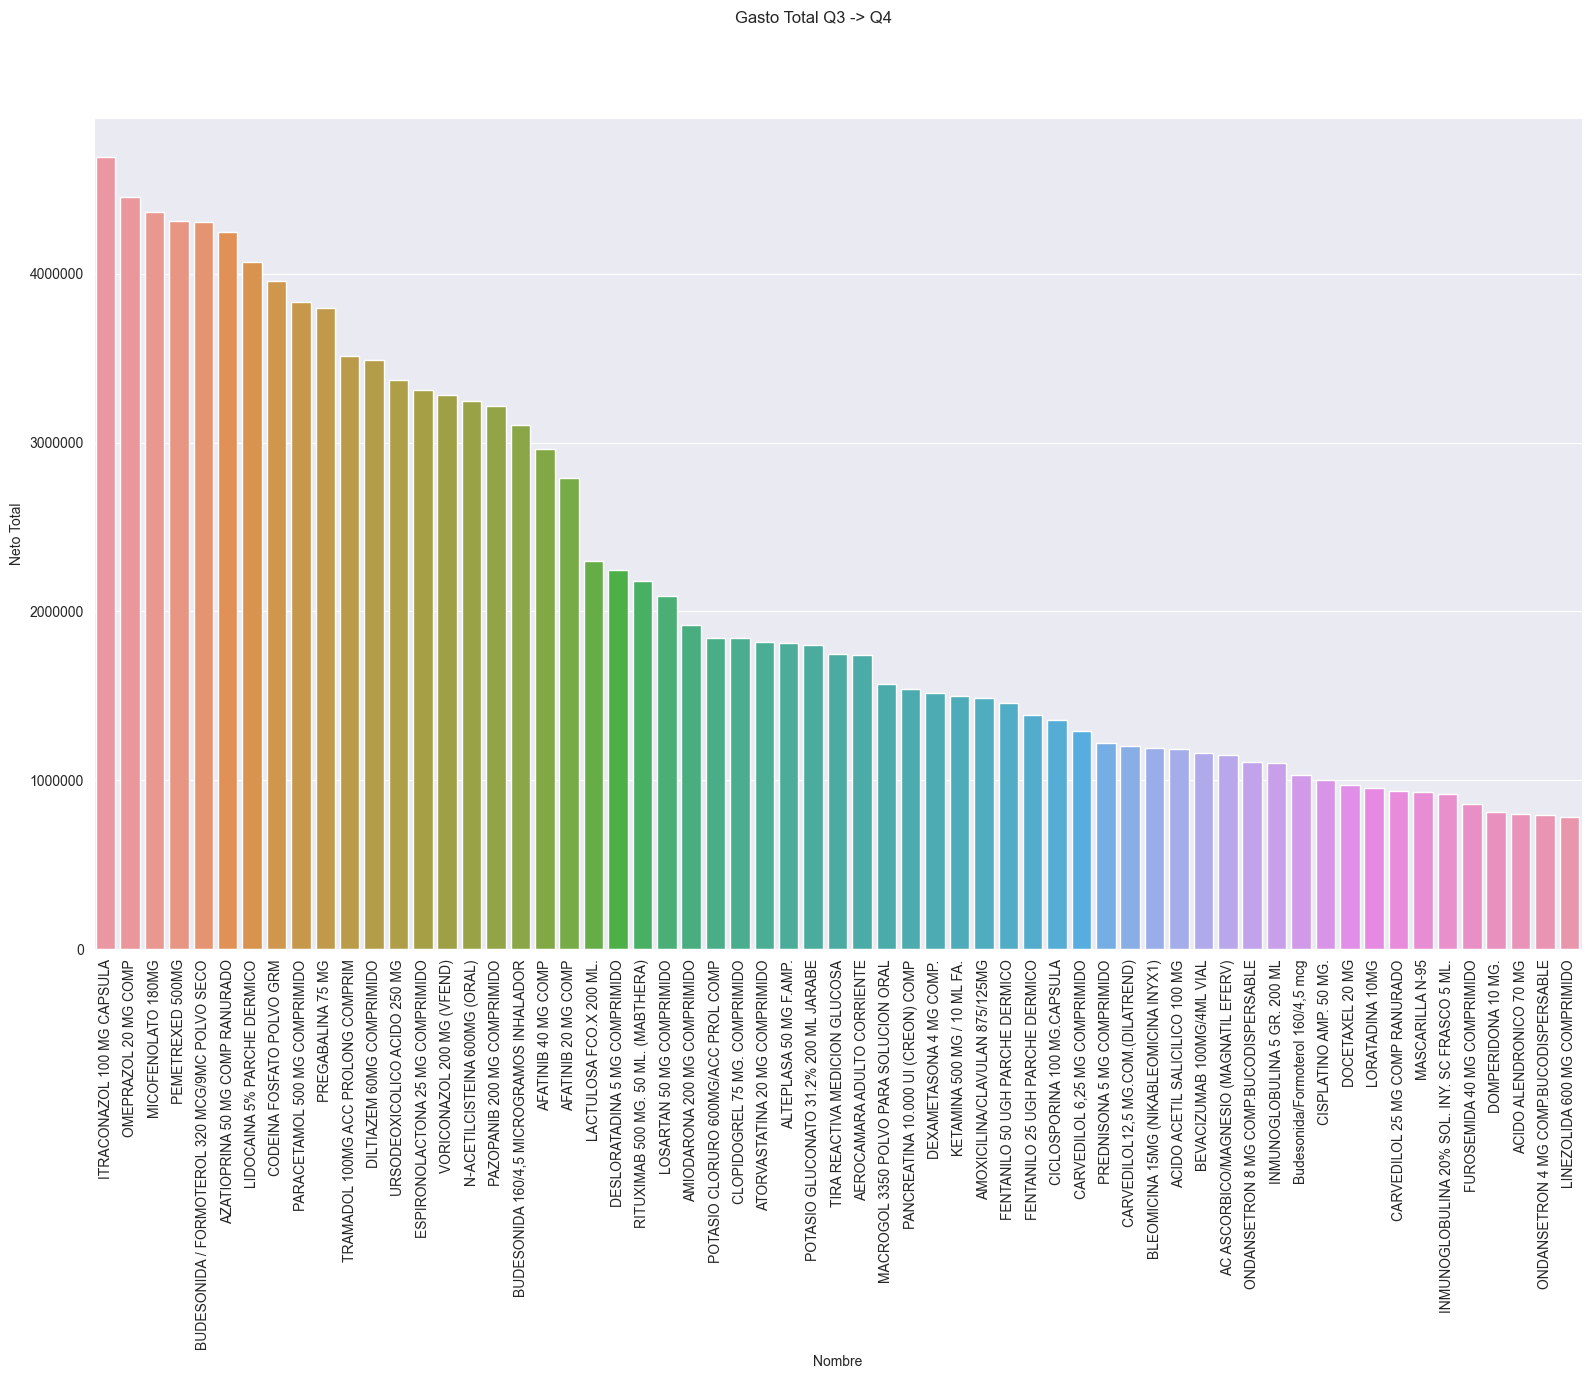

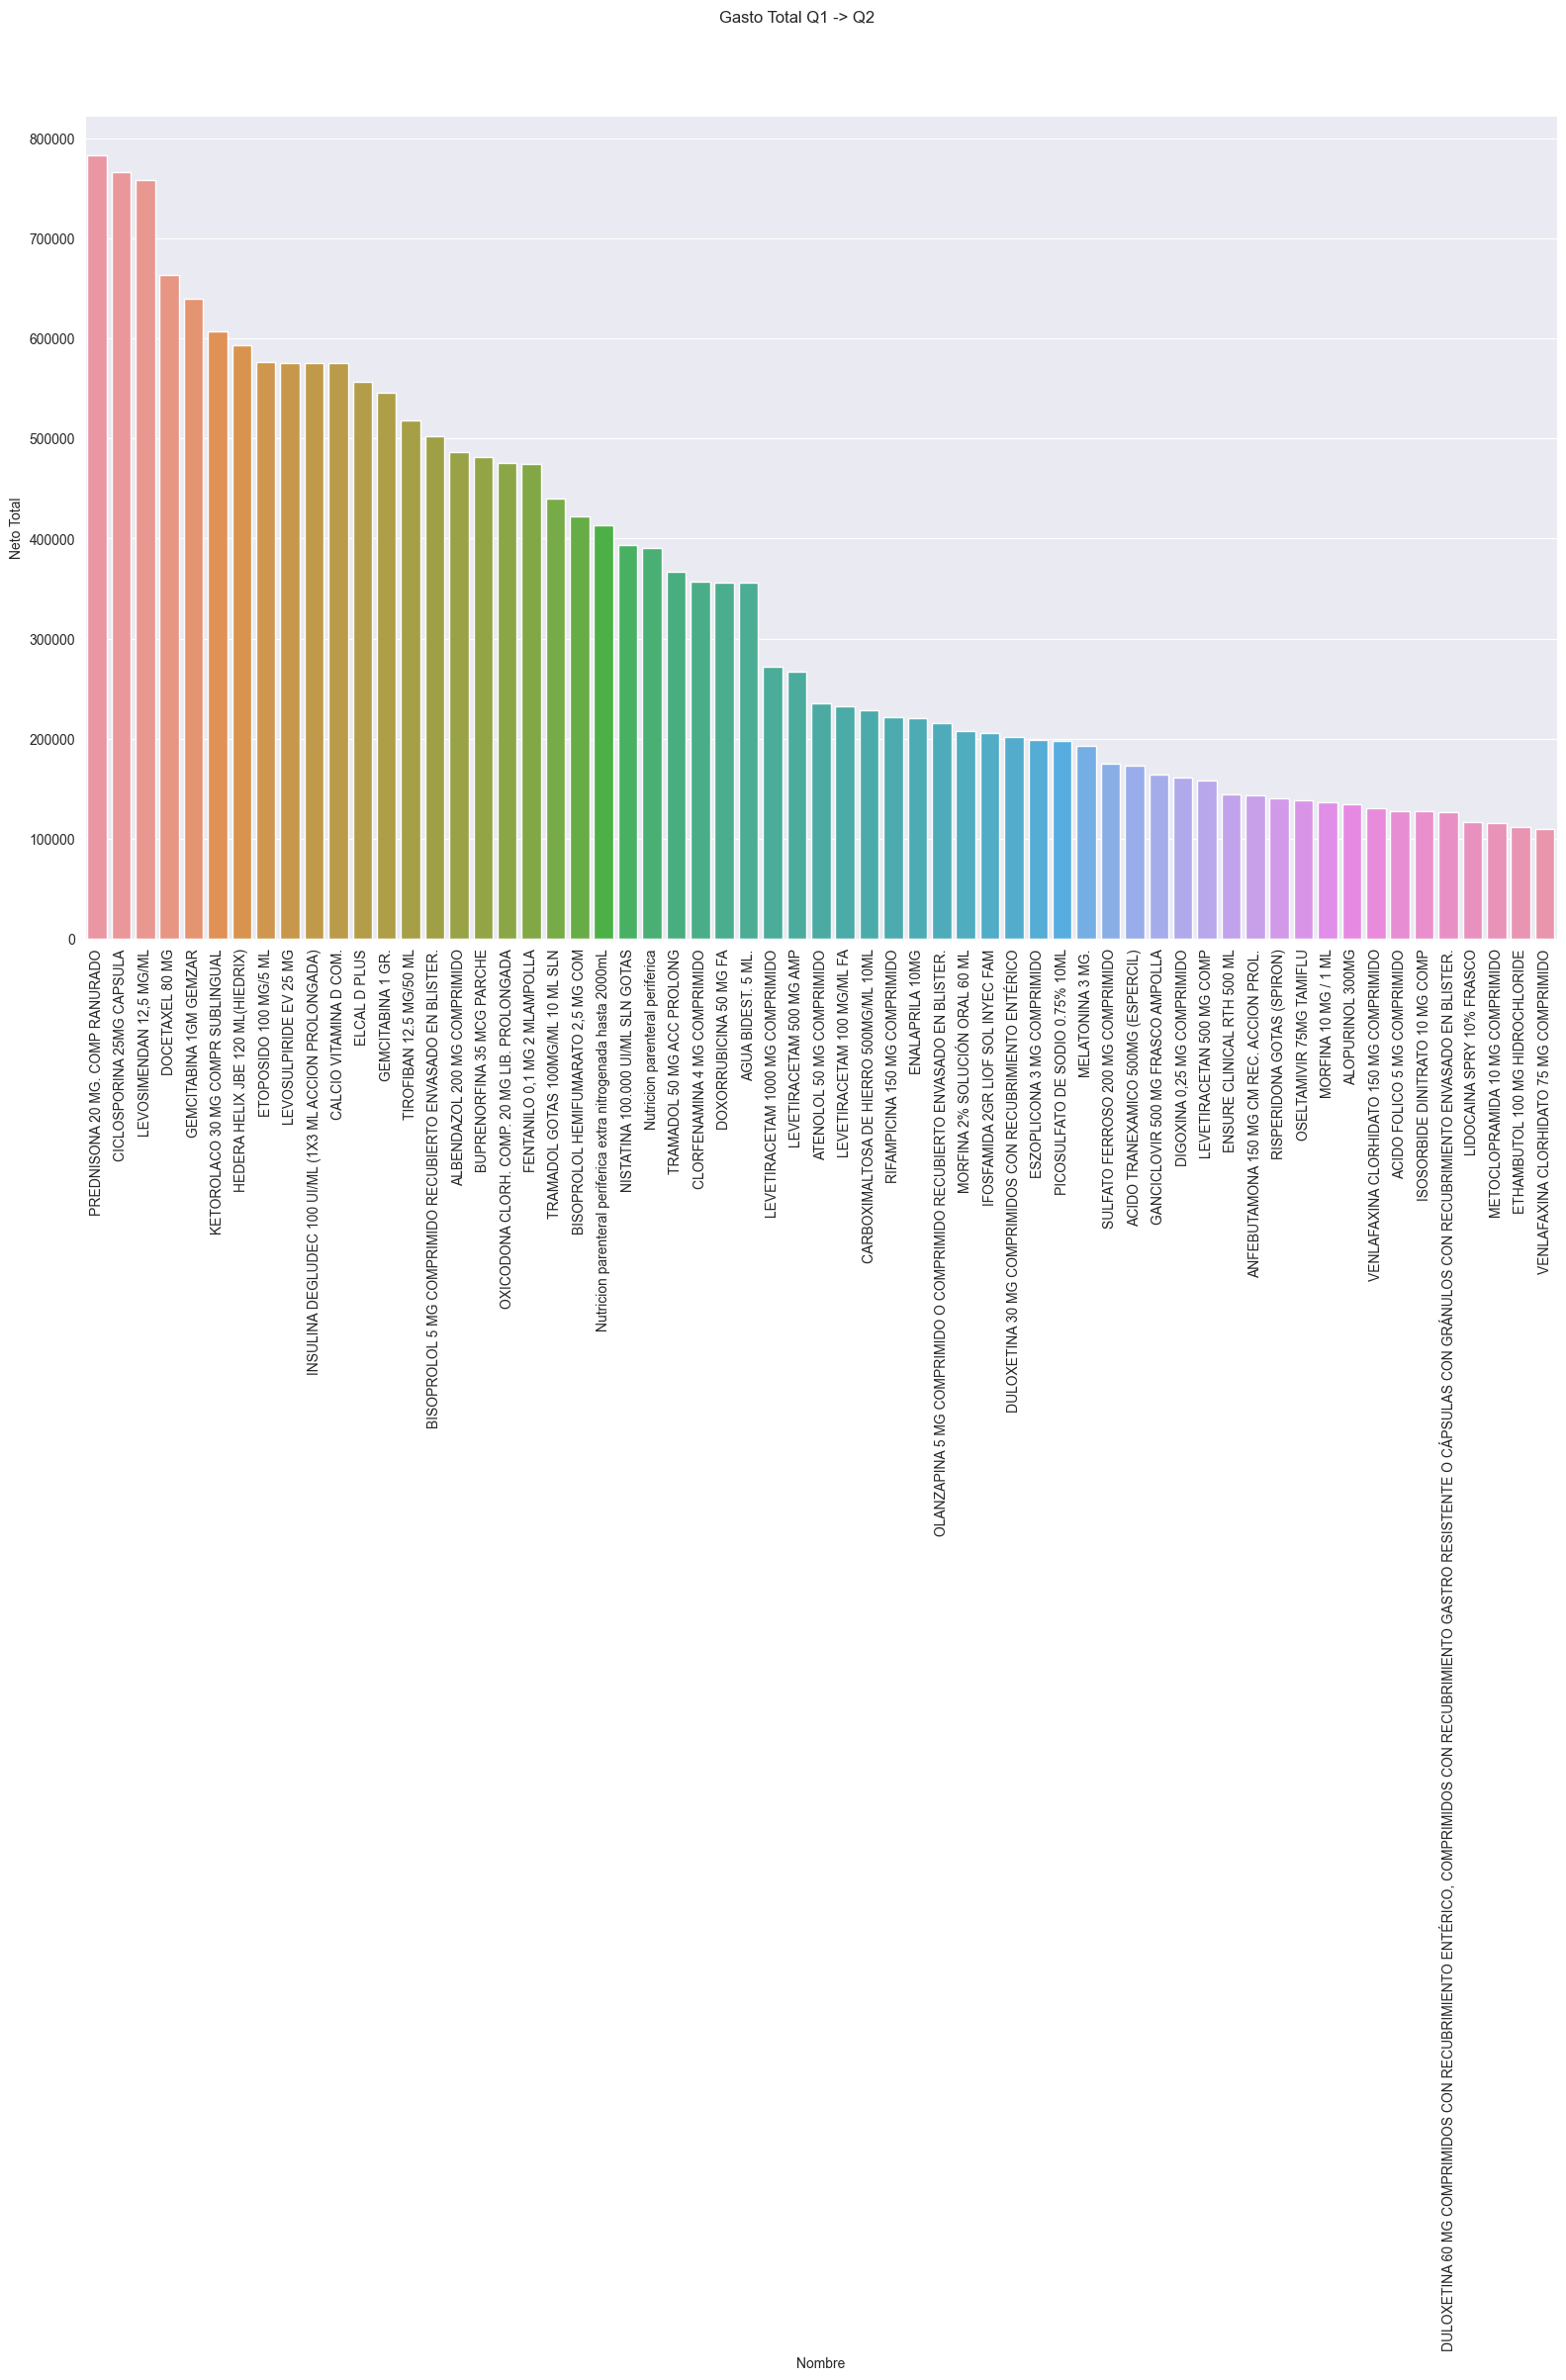

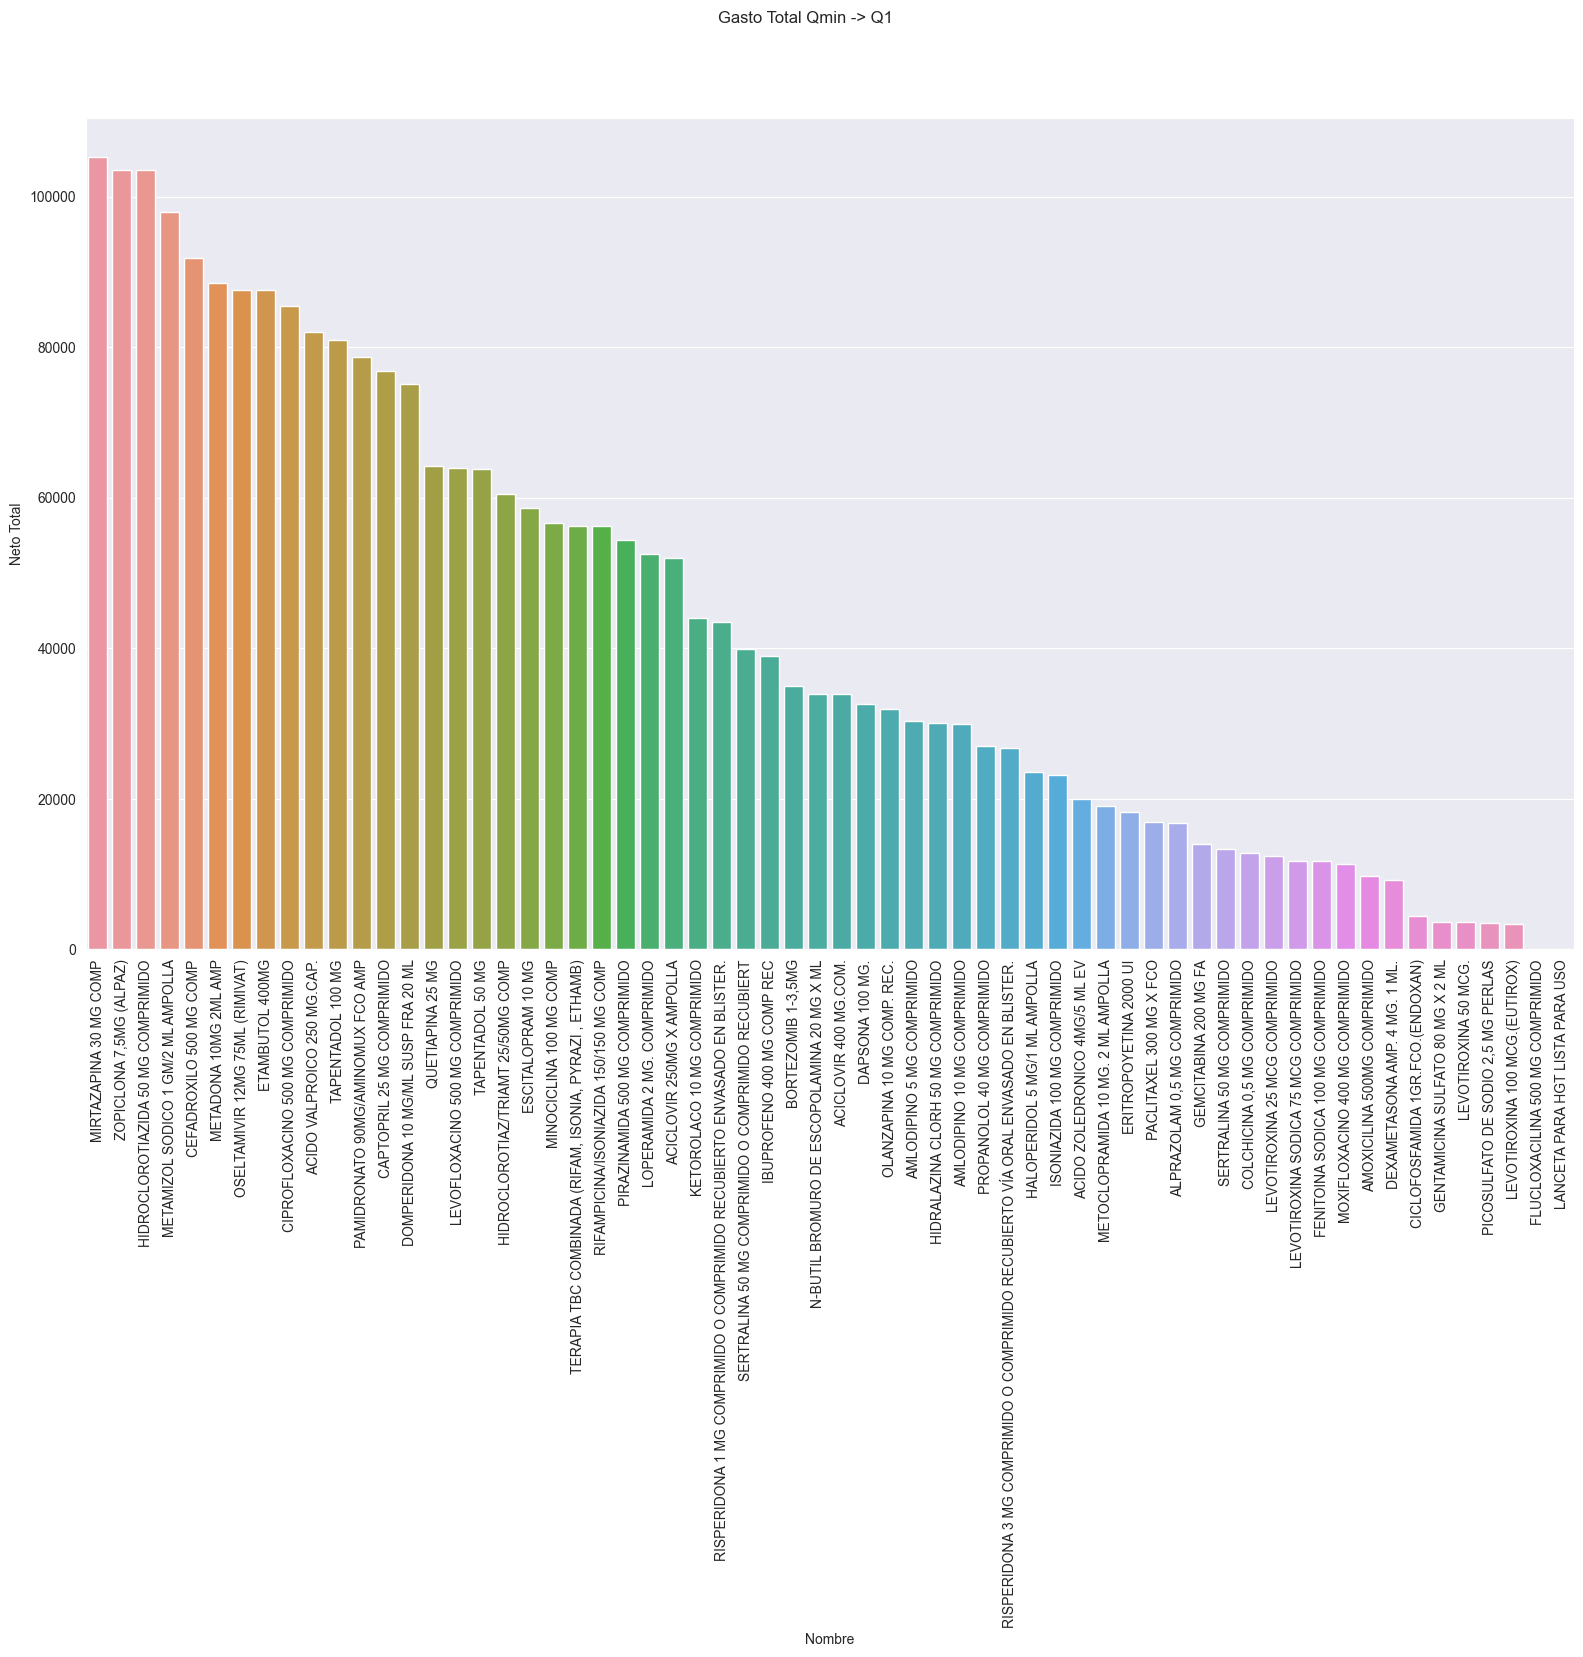

In [284]:
for servicio in costos_por_unidades['Destino']:
    obtener_gasto_por_servicio(df_salidas, servicio)
    break

In [285]:
figura_gasto_neto_global.savefig('output.svg')